# Accelerometer data report (Multi Event Multi Sensor)

## Read CSV Files

In [3]:
import pandas as pd
from collections import namedtuple

## read crystal- and dco- timestamped data
columns = ['Timestamp', 'X', 'Y', 'Z'];

# Store data into named tuple
LimbData = namedtuple("LimbData", "Crystal DCO");

# Get left pocket (LP) data
crystal_df_lp = pd.read_csv('../Data/Crystal_accel_COM10_4MHz_1.csv', names=columns);
crystal_lp = crystal_df_lp.as_matrix();
dco_df_lp = pd.read_csv('../Data/DCO_accel_COM10_2MHz_1.csv', names=columns);
dco_lp = dco_df_lp.as_matrix();
LP = LimbData(crystal_lp, dco_lp);

# Get right pocket (RP) data
crystal_df_rp = pd.read_csv('../Data/Crystal_accel_COM7_4MHz_1.csv', names=columns);
crystal_rp = crystal_df_rp.as_matrix();
dco_df_rp = pd.read_csv('../Data/DCO_accel_COM7_2MHz_1.csv', names=columns);
dco_rp = dco_df_rp.as_matrix();
RP = LimbData(crystal_rp, dco_rp);

# Get Right Forearm data
crystal_df_rf = pd.read_csv('../Data/Crystal_accel_COM5_4MHz_1.csv', names=columns);
crystal_rf = crystal_df_rf.as_matrix();
dco_df_rf = pd.read_csv('../Data/DCO_accel_COM5_2MHz_1.csv', names=columns);
dco_rf = dco_df_rf.as_matrix();
RF = LimbData(crystal_rf, dco_rf);

# Get other person's right wrist
crystal_df_rw = pd.read_csv('../Data/Crystal_accel_COM13_4MHz_1.csv', names=columns);
crystal_rw = crystal_df_rw.as_matrix();
dco_df_rw = pd.read_csv('../Data/DCO_accel_COM13_2MHz_1.csv', names=columns);
dco_rw = dco_df_rw.as_matrix();
RW = LimbData(crystal_rw, dco_rw);

# We now have all our data sets as named tuples: LP, RP, RF, and RW

# Let's plot the movements between RP and LP and see if we can catch vibrations 


## Check some drifts

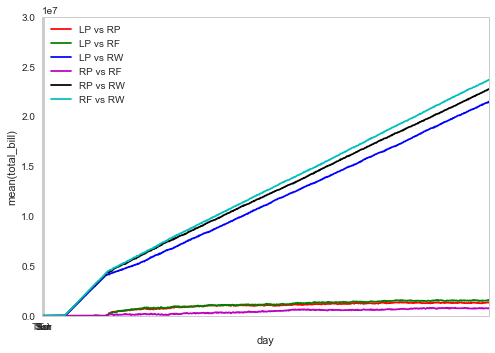

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

limbs=["LP", "RP", "RF", "RW"];
colors=['r', 'g', 'b', 'm', 'k', 'c'];
limbArray = [LP, RP, RF, RW];
count = 0;

# Plotting all drifts
for i in range(0, len(limbArray)-1):
    R = limbArray[i];
    for j in range(i+1, len(limbArray)):
        L = limbArray[j];
        l = limbs[i] + " vs " + limbs[j]
        
        # Compute elapsed times
        ctime = R.Crystal[:,0];
        ctime = ctime - ctime[0];

        dtime = L.DCO[:,0];
        dtime = dtime - dtime[0];

        # Let ctime array be reference
        dtime_interp = interp.interp1d(np.arange(dtime.size), dtime);
        dtime_stretch = dtime_interp(np.linspace(0, dtime.size-1, ctime.size));
        dtime = dtime_stretch;

        drift = abs(dtime - ctime);

        samples = np.linspace(0, len(drift), num=len(drift))

        xp = np.linspace(0, len(drift), 100);

        deg = 1;
        z1 = np.poly1d(np.polyfit(samples, drift, deg))

        plt.plot(drift, colors[count], label=l);
        count += 1;
        
plt.ylim([0,30000000])
plt.xlim([0,800])
plt.legend();
plt.grid()
plt.show()


Drifts exist, we can replace RP and LP with any other of the COM variables pulled, and a linear drift will still appear.

# Let's see if we can find steps

## High pass filter

In [5]:
from scipy import signal
# Quick define a high pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y


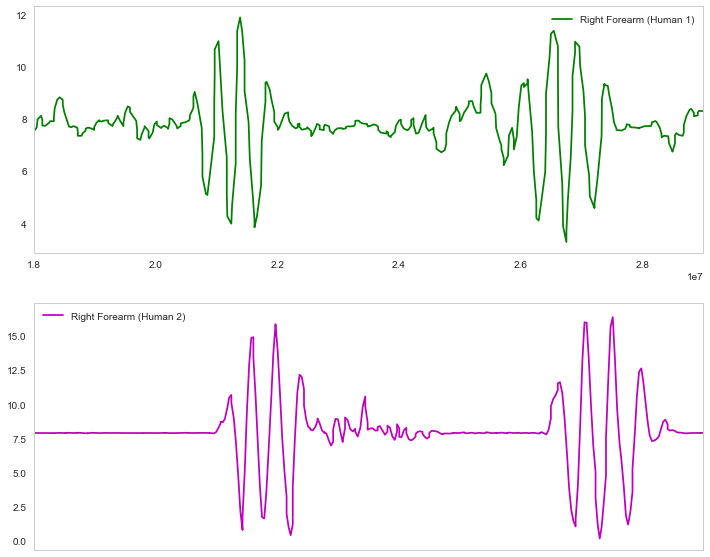

In [6]:
freq = 50 
cutoff = 12
# Get magnitude of LP and RP
RPTime = RP.Crystal[:,0];
RPTime = RPTime - RPTime[0];
RPMag = np.square(RP.Crystal[:,1]) + np.square(RP.Crystal[:,2]) + np.square(RP.Crystal[:,3]);
RPMag = np.sqrt(RPMag);
RPMag = butter_lowpass_filter(RPMag, cutoff, freq);

LPTime = LP.DCO[:,0];
LPTime = LPTime - LPTime[0];
LPMag = np.square(LP.DCO[:,1]) + np.square(LP.DCO[:,2]) + np.square(LP.DCO[:,3]);
LPMag = np.sqrt(LPMag);
LPMag = butter_lowpass_filter(LPMag, cutoff, freq);

RFTime = RF.DCO[:,0];
RFTime = RFTime - RFTime[0];
RFMag = np.square(RF.DCO[:,1]) + np.square(RF.DCO[:,2]) + np.square(RF.DCO[:,3]);
RFMag = np.sqrt(RFMag);
RFMag = butter_lowpass_filter(RFMag, cutoff, freq);

RWTime = RW.DCO[:,0];
RWTime = RWTime - RWTime[0];
RWMag = np.square(RW.DCO[:,1]) + np.square(RW.DCO[:,2]) + np.square(RW.DCO[:,3]);
RWMag = np.sqrt(RWMag);
RWMag = butter_lowpass_filter(RWMag, cutoff, freq);

fig, (ax3, ax4) = plt.subplots(nrows=2);

#ax1.plot(RPTime, abs(RPMag), 'r', label="Right Pocket");
#ax1.set_xlim([0, 20000000])
#ax1.set_ylim([0, 3.5])
#ax1.legend();
#ax1.grid();

#ax2.plot(LPTime, abs(LPMag), 'b', label="Left Pocket");
#ax2.set_xlim([0, 20000000])
#ax2.set_ylim([0, 3.5])
#ax2.legend();
#ax2.grid();

ax3.plot(RFTime, abs(RFMag), 'g', label="Right Forearm (Human 1)");
ax3.legend();
ax3.grid();
ax3.set_xlim([18000000, 29000000])

frame = plt.gca()
frame.xaxis.set_major_formatter(plt.NullFormatter())

ax4.plot(RWTime, abs(RWMag), 'm', label="Right Forearm (Human 2)");
ax4.legend();
ax4.grid();
ax4.set_xlim([65000000, 76000000])

#



#fig, (ax1, ax2) = plt.subplots(nrows=2);

#
#

#ax1.plot(RFTime, RFMag, 'g');
#ax1.grid();
#ax1.set_xlim([10000000, 50000000])

#ax2.plot(RWTime, RWMag, 'm');
#ax2.grid();
#ax2.set_xlim([60000000, RWTime[-1]])


plt.show();



## Fix up the drift

In [7]:
# Fixing up drift code is too complex to put in this noteboook, 
# instead it's done in a separate class
import scipy as sp
from scipy.signal import correlate

def find_offset(data1, data2):
    #sample rate
    SRATE=50;
    
    # delta time array to match xcorr
    nsamples = max(len(data1), len(data2));
    
    #Regularize datasets by subtracting mean and dividing by s.d.
    data1 -= data1.mean();
    data1 /= data1.std();

    data2 -= data2.mean();
    data2 /= data2.std();

    # Find X-correlation
    xcorr = correlate(data1, data2);

    # delta time array to match xcorr
    dt = np.arange(1-nsamples, nsamples);
    recovered_sample_shift = dt[xcorr.argmax()];
    offset = recovered_sample_shift * SRATE;
    
    return offset

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

limbs=["LP", "RP", "RF", "RW"];
colors=['r', 'g', 'b', 'm', 'k', 'c'];
limbArray = [LP, RP, RF, RW];
count = 0;

# Plotting all drifts
fig, (ax1, ax2) = plt.subplots(ncols=2);

for i in range(0, len(limbArray)-1):
    R = limbArray[i];
    for j in range(i+1, len(limbArray)):
        L = limbArray[j];
        l = limbs[i] + " vs " + limbs[j]
        
        # Compute elapsed times
        ctime = R.Crystal[:,0];
        ctime = ctime - ctime[0];

        dtime = L.DCO[:,0];
        dtime = dtime - dtime[0];
        
        # Let ctime array be reference
        dtime_interp = interp.interp1d(np.arange(dtime.size), dtime);
        dtime_stretch = dtime_interp(np.linspace(0, dtime.size-1, ctime.size));
        dtime = dtime_stretch;

        drift = abs(dtime - ctime);

        samples = np.linspace(0, len(drift), num=len(drift))

        xp = np.linspace(0, len(drift), 100);

        deg = 1;
        z1 = np.poly1d(np.polyfit(samples, drift, deg))

        #plt.plot(xp, z1(xp), colors[count], label=l);
        ax1.plot(drift, colors[count], label=l);
        count += 1;
        
#ax1.set_ylim([0,10000000])
ax1.set_ylabel("Drift(millis)");
ax1.set_xlabel("Samples")
ax1.set_xlim([75,len(drift)])
ax1.legend();
ax1.grid()


count = 0;
# Now plot improvements
for i in range(0, len(limbArray)-1):
    R = limbArray[i];
    for j in range(i+1, len(limbArray)):
        L = limbArray[j];
        l = limbs[i] + " vs " + limbs[j]
        
        # Compute elapsed times
        ctime = R.Crystal[:,0];
        ctime = ctime - ctime[0];

        dtime = L.DCO[:,0];
        dtime = dtime - dtime[0];
        
        
        # Let ctime array be reference
        dtime_interp = interp.interp1d(np.arange(dtime.size), dtime);
        dtime_stretch = dtime_interp(np.linspace(0, dtime.size-1, ctime.size));
        dtime = dtime_stretch;

        drift = abs(dtime - ctime);
        
        offset = find_offset(dtime, ctime)
        skew = skews[count];
        dtime = (dtime * skew) + offset;

        adjusted_drift = abs(dtime - ctime);
        
        samples = np.linspace(0, len(drift), num=len(drift))

        xp = np.linspace(0, len(drift), 100);

        deg = 1;
        z1 = np.poly1d(np.polyfit(samples, adjusted_drift, deg))

        ax2.plot(xp, z1(xp), colors[count], label=l);
        #ax2.plot(adjusted_drift, colors[count], label=l);
        count += 1;
        
        # Plot average improvement over no-drift
        #print ("In the case of ", l)
        #avg_drift = sum(drift) / len(drift);
        #adjusted_drift_avg = sum(adjusted_drift) / len(adjusted_drift);
        #decrease = avg_drift - adjusted_drift_avg;
        #print("Drift reduced by %.2f%%" % ((decrease / avg_drift) * 100), "\n")

ax2.set_ylabel("Drift(millis)");
ax2.set_xlabel("Samples")
ax2.set_ylim([0,2])
ax2.set_xlim([75,len(drift)])
ax2.legend();
ax2.grid()

plt.show()


NameError: name 'skews' is not defined

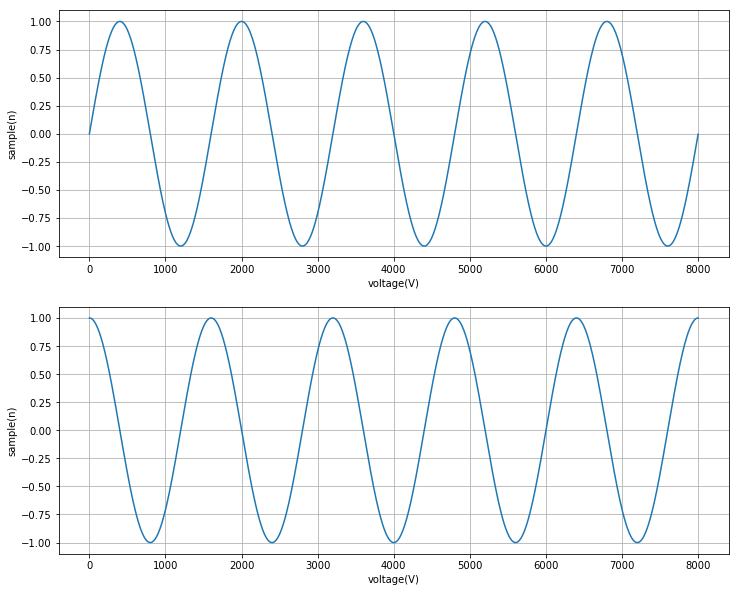

X-CORR:  0.048875


In [151]:
# Quick x-corr sandbox
import scipy as sp
from scipy.signal import correlate
from scipy.stats.stats import pearsonr   
#sample rate
SRATE=50;

Fs = 8000
f = 5
sample = 8000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)
#y2 = np.ones(sample) * 0.2;

y2 = np.cos(2 * np.pi * f * x / Fs)

fig, (ax1, ax2) = plt.subplots(nrows=2);
ax1.plot(x, y)
ax1.grid();
ax1.set_xlabel('voltage(V)')
ax1.set_ylabel('sample(n)')

ax2.plot(x, y2)
ax2.grid();
ax2.set_xlabel('voltage(V)')
ax2.set_ylabel('sample(n)')

plt.show()

si = y;
co = y2;



# Find normalized X-correlation
si -= si.mean();
si /= si.std();

co -= co.mean();
co /= co.std();


xcorr = correlate(si, co);
dt = np.arange(1-sample, sample);
recovered_sample_shift = dt[xcorr.argmax()];
print("X-CORR: ", recovered_sample_shift/sample)




   Accuracy        Activity
0        95  Step Detection
1        90  Step Detection
2        92  Step Detection
3        85       Key Press
4        93       Key Press
5        95       Key Press
6        95       Handshake
7        95       Handshake
8        97       Handshake


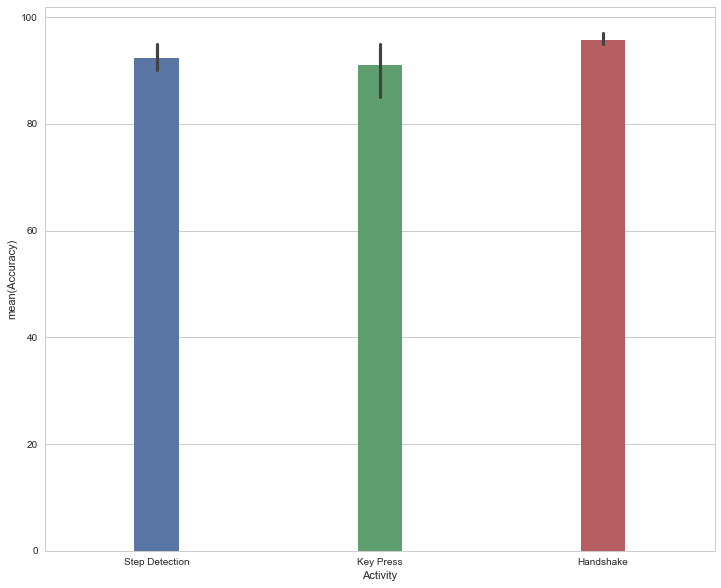

In [8]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

sns.set_style("whitegrid")
mm = [95, 90, 92,85, 93, 95,95, 95, 97];
activities = ['Step Detection','Step Detection','Step Detection','Key Press','Key Press','Key Press', 'Handshake','Handshake','Handshake'];

accuracies = {'Accuracy': mm, 'Activity':activities};
tips = sns.load_dataset("tips")

df = pd.DataFrame(data=accuracies)
print (df);

ax = sns.barplot(x="Activity", y="Accuracy", data=df)

# Set these based on your column counts
columncounts = [20,20,20]

# Maximum bar width is 1. Normalise counts to be in the interval 0-1. Need to supply a maximum possible count here as maxwidth
def normaliseCounts(widths,maxwidth):
    widths = np.array(widths)/float(maxwidth)
    return widths

widthbars = normaliseCounts(columncounts,100)

# Loop over the bars, and adjust the width (and position, to keep the bar centred)
for bar,newwidth in zip(ax.patches,widthbars):
    x = bar.get_x()
    width = bar.get_width()
    centre = x+width/2.

    bar.set_x(centre-newwidth/2.)
    bar.set_width(newwidth)

plt.show()

## Checking out how drift changes over time for a longitudinal data study

95931803907
95931792181


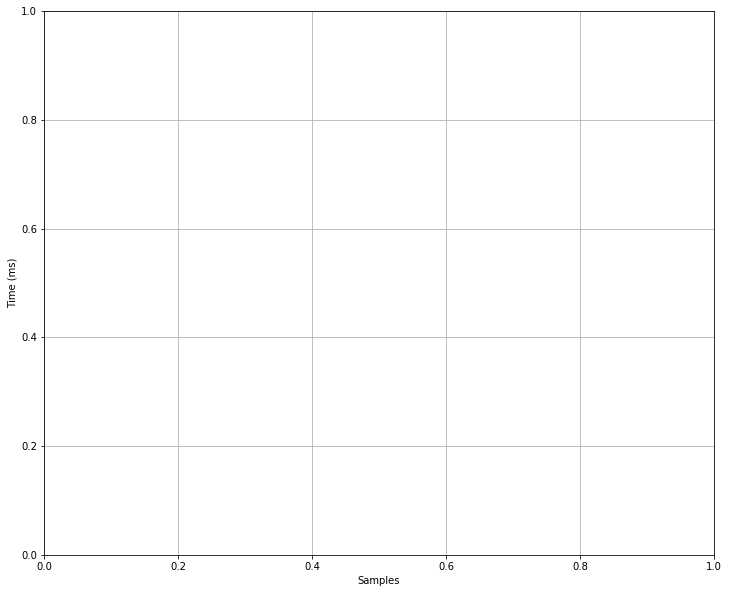

In [5]:
import pandas as pd
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import mpld3
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (12.0, 10.0)

## read crystal- and dco- timestamped data
columns = ['Timestamp','Type', 'X', 'Y', 'Z'];

# Store data into named tuple
SourceData = namedtuple("SourceData", "Crystal DCO");

# Get left pocket (LP) data
#COM12_df = pd.read_csv('../Data/Longitudinalraw_output_COM12.csv', names=columns, low_memory=False);
#COM12Crystal = COM12_df.loc[COM12_df['Type'] == 'C'];
#COM12DCO = COM12_df.loc[COM12_df['Type'] == 'D']
#Crystal1 = COM12Crystal.as_matrix();
#DCO1 = COM12DCO.as_matrix();
#R = SourceData(Crystal1, DCO1);

#COM13_df = pd.read_csv('../Data/Longitudinalraw_output_COM13.csv', names=columns, low_memory=False);
#COM13Crystal = COM13_df.loc[COM13_df['Type'] == 'C'];
#COM13DCO = COM13_df.loc[COM13_df['Type'] == 'D']
#Crystal2 = COM13Crystal.as_matrix();
#DCO2 = COM13DCO.as_matrix();
#L = SourceData(Crystal2, DCO2);


# Compute elapsed times
ctime = R.Crystal[:,0];
dtime = L.Crystal[:,0];
print(ctime[-1] - ctime[0]);
print(dtime[-1] - dtime[0])

ctime = (ctime - ctime[0])/1000;
dtime = (dtime - dtime[0])/1000;

diff = abs(len(dtime) - len(ctime));

if(len(dtime) > len(ctime)):
    dtime = dtime[:-diff];
else:
    ctime = ctime[:-diff];

# Let ctime array be reference
#dtime_interp = interp.interp1d(np.arange(dtime.size), dtime);
#ctime_interp = interp.interp1d(np.arange(ctime.size), ctime);

#dtime_stretch = dtime_interp(np.linspace(0, dtime.size-1, ctime.size));
#ctime_compress = ctime_interp(np.linspace(0, dtime.size-1, ctime.size));
#dtime = dtime_stretch;
#ctime = ctime_compress;

drift = abs(dtime - ctime);

samples = np.linspace(0, len(drift), num=len(drift))

xp = np.linspace(0, len(drift), 100);



deg = 10;
z1 = np.poly1d(np.polyfit(samples, drift, deg))
#plt.plot(drift, label="drift")
#plt.plot(xp, z1(xp), label="drift");
plt.xlabel("Samples");
plt.ylabel("Time (ms)")
plt.grid();
plt.show();